In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

import libpysal
from libpysal import weights
from libpysal.weights.util import min_threshold_distance

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran
from splot.libpysal import plot_spatial_weights

sns.set_style('darkgrid')
#sns.set_style('whitegrid')

# !pip install pandas
# !pip install ipyleaflet
# !pip install ipywidgets
# !pip install gmaps
# !pip install widgetsnbextension
# !jupyter nbextension enable --py --sys-prefix widgetsnbextension
# !jupyter nbextension enable --py --sys-prefix gmaps

import os
os.listdir('Trimble/AgGPS/Data/Hackathon/Hackathon/3_2')

In [ ]:
# test

# import pyproj
# crs = pyproj.CRS("+proj=laea +lat_0=45 +lon_0=-100 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")
# crs.to_epsg()
# from pyproj import CRS
# crs_utm = CRS.from_user_input(26915)
# crs_utm

In [494]:
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString, mapping, MultiPolygon, MultiPoint
from shapely.ops import nearest_points
from ipyleaflet import Map, GeoData, basemaps, Polyline, Marker, Circle, LayerGroup

# param_offset - безопасное расстояние от техники до границы участка. 2,8 м - сеялка, 6 м - опрыскиватель
# param_step - расстояние между проходами 5,6 м - сеялка, 11,9 м - опрыскиватель

In [126]:
shp_pole = gpd.read_file("Trimble/Pole.shp").set_crs("WGS84")
display(shp_pole)
display(shp_pole.crs)

,__ID42,Client_ID,ClientName,Farm_ID,FarmName,Field_ID,FieldName,CropYear,Commod_ID,CommodName,Size,geometry
0,1555871335,176,Hackathon,110,Hackathon,116,Pole,None,None,None,4.09,"POLYGON ((26.97199 53.21268, 26.97176 53.21278..."


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
pole_center_WGS84 = shp_pole.to_crs(epsg=2584).centroid.to_crs('WGS84').item().coords[0]
m = Map(center=(pole_center_WGS84[1],pole_center_WGS84[0]), zoom = 17, basemap=basemaps.Esri.WorldImagery)

geo_pole = GeoData(geo_dataframe = shp_pole, 
                   style={'fillColor': 'blue', 'opacity':0.5, 'weight':1, 'fillOpacity':0.2},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.15})
m.add_layer(geo_pole)
m

Map(center=[53.212486567581415, 26.974399482656573], controls=(ZoomControl(options=['position', 'zoom_in_text'…

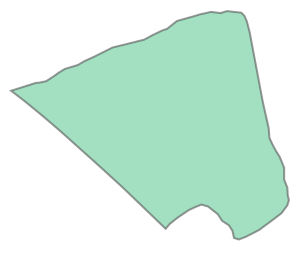

<Derived Projected CRS: EPSG:2584>
Name: Pulkovo 1942 / 3-degree Gauss-Kruger CM 27E
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Belarus, Estonia, Latvia, Lithuania, Moldova, Russian Federation and Ukraine - onshore between 25°30'E and 28°30'E.
- bounds: (25.49, 45.26, 28.51, 68.93)
Coordinate Operation:
- name: Gauss-Kruger CM 27E
- method: Transverse Mercator
Datum: Pulkovo 1942
- Ellipsoid: Krassowsky 1940
- Prime Meridian: Greenwich

In [4]:
geom_pole = shp_pole.to_crs(epsg=2584).geometry
display(geom_pole.item())
geom_pole.crs

In [5]:
print(f"Геометрический центр: https://earth.google.com/web/search/{pole_center_WGS84[1]:.5f}"
      f"{pole_center_WGS84[0]:.5f}")
print(f"Длина периметра: {geom_pole.item().length:.2f}")
print(f"Площадь: {geom_pole.item().area:.2f}")

Геометрический центр: https://earth.google.com/web/search/53.2124926.97440
Длина периметра: 871.23
Площадь: 41115.66


In [173]:
list_points = mapping(geom_pole.item())['coordinates'][0]
point_prev = Point(list_points[0])
reference_line = LineString([point_prev, point_prev])
max_dist = 0
for x in list_points:
    point_cur = Point(x)
    reference_line = LineString(list(reference_line.coords)+[point_cur])
    while reference_line.convex_hull.area > 100:
        reference_line = LineString(reference_line.coords[1:])
#     print(reference_line.convex_hull.area, reference_line.length)
#     display(reference_line.convex_hull)
    dist = point_cur.distance(Point(reference_line.coords[0]))
    if dist > max_dist:
        max_dist = dist
        max_reference_line = reference_line
        print(reference_line.length)
        
    point_prev = Point(x)


18.770964630514236
28.096502431251523
30.643928856481402
38.9080065647028
47.50432859912097
57.228229886613235
71.43250629629091
93.83486233684357
116.48148098723826
154.17921288420453


In [174]:
geo_pole = GeoData(geo_dataframe = shp_pole, 
                   style={'fillColor': 'blue', 'opacity':0.5, 'weight':1, 'fillOpacity':0.2},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.15})
list_points_WGS84 = list((y,x) for (x,y) in mapping(geom_pole.to_crs('WGS84').item())['coordinates'][0])
line = Polyline(
    locations=list_points_WGS84,
    color="green" ,
    fill=False
)

geo_reference_line = gpd.GeoSeries(max_reference_line).set_crs(epsg=2584, inplace=True)
reference_line_WGS84 = list((y,x) for (x,y) in mapping(geo_reference_line.to_crs('WGS84').item())['coordinates'])
line_ref = Polyline(
    locations=reference_line_WGS84,
    color="purple" ,
    fill=False
)

points_group = []
points_group += [Circle(location=list_points_WGS84[0], radius=1, color="blue")]
for point in list_points_WGS84[1:-1]:
    points_group += [Circle(location=point, radius=1, color="yellow")]
points_group += [Circle(location=list_points_WGS84[-1], radius=5, color="red")]
layer_group = LayerGroup(layers=points_group)

m = Map(center=(pole_center_WGS84[1],pole_center_WGS84[0]), zoom = 17, basemap=basemaps.Esri.WorldImagery)
m.add_layer(geo_pole)
m.add_layer(line)
m.add_layer(line_ref)
m.add_layer(layer_group)
m

Map(center=[53.212486567581415, 26.974399482656573], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [175]:
max_reference_line.coords[0], max_reference_line.coords[-1]

((498404.47001925943, 5898277.341656349),
 (498291.4228050793, 5898382.154415578))

# Афинные преобразования - вращение

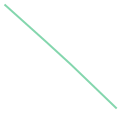

'Поворачиваем на угол -0.74762 рад.'

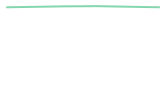

In [176]:
display(max_reference_line)
alpha = np.arctan((max_reference_line.coords[0][1]-max_reference_line.coords[-1][1])/
                  (max_reference_line.coords[0][0]-max_reference_line.coords[-1][0]))
display(f"Поворачиваем на угол {alpha:.5f} рад.")
alpha
affinity.rotate(max_reference_line, -alpha, use_radians = True, origin='centroid')

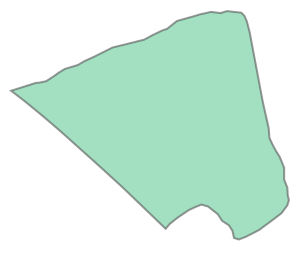

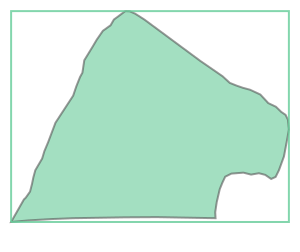

In [177]:
display(geom_pole.item())
norm_pole = affinity.rotate(geom_pole.item(), -alpha, use_radians = True, origin='centroid')
minx, miny, maxx, maxy = norm_pole.bounds
Polygon(((minx, miny),(minx, maxy),(maxx, maxy),(maxx, miny),(minx, miny))).boundary.union(norm_pole)

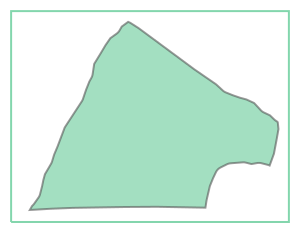

In [182]:
param_step = 5.6 # сеялка
param_offset = param_step*2

norm_pole_offset = Polygon(norm_pole.boundary.parallel_offset(param_offset, 'right'))
Polygon(((minx, miny),(minx, maxy),(maxx, maxy),(maxx, miny),(minx, miny))).boundary.union(norm_pole_offset)

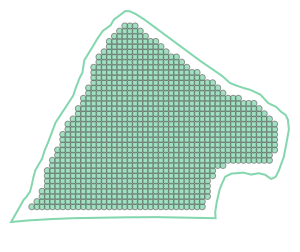

In [401]:
# Сдвиг сетки будем менять в поиске наилучшего результата
slice_x = 0
slice_y = -0.3

grid_x = []
x = minx + slice_x
while x < maxx:
    grid_x += [x]
    x += param_step

grid_y = []
y = miny + slice_y
while y < maxy:
    grid_y += [y]
    y += param_step

full_grid_xy = MultiPoint([(x,y) for x in grid_x for y in grid_y]).intersection(norm_pole)
grid_xy = full_grid_xy.intersection(norm_pole_offset)
norm_pole.boundary.union(grid_xy)

In [408]:
norm_pole.centroid.coords[0]

(498415.2414398589, 5898391.836893942)

In [416]:
# mapping(norm_pole.boundary.union(MultiPoint(path_line)))

In [320]:
len(grid_xy.geoms)

1031

In [702]:
def turn_path(p1, p2, left_to_right):

    r = 5
    
    x1, y1 = p1.coords[0]
    x2, y2 = p2.coords[0]

    delta_y = (y2-y1)/2
    delta_x = np.sqrt(r*r-delta_y*delta_y)

    if left_to_right:
        t_1 = Point(x1+delta_x, y1+delta_y-r)
        t_2 = Point(x1+delta_x*2, y1)
        t_3 = Point(x1+delta_x+r, y1+delta_y)
        t_4 = Point(x1+delta_x*2, y2)
        t_5 = Point(x1+delta_x, y2-delta_y+r)
    else:
        t_1 = Point(x1-delta_x, y1+delta_y-r)
        t_2 = Point(x1-delta_x*2, y1)
        t_3 = Point(x1-delta_x-r, y1+delta_y)
        t_4 = Point(x1-delta_x*2, y2)
        t_5 = Point(x1-delta_x, y2-delta_y+r)
    return [t_1, t_2, t_3, t_4, t_5, p2]


# Построение маршрута по полю

In [703]:
s = gpd.GeoSeries(grid_xy.geoms)
search_point = Point(minx, miny)
find_point = s[s.distance(search_point)==s.distance(search_point).min()]
p = find_point.item()
path_line = [p]
s.drop(find_point.index, inplace=True)

left_to_right = True
extra = False
while len(s)>0:
    print(len(s), end =' \r')
    # сохраняем движение, если дальше нет ничего, проверяем диагональ, если там есть точка, продолжаем движение
    if left_to_right:
        search_point = Point(p.coords[0][0]+param_step, p.coords[0][1])
        find_point = s[s.distance(search_point)<0.1]
        if len(find_point)>0:
            extra = False
            p = find_point.item()
            path_line += [p]
            s.drop(find_point.index, inplace=True)
        elif extra:
            # продолжаем движение с заездом на маршрут вдоль периметра
            p = search_point
            path_line += [search_point]
        else:
            search_point = Point(p.coords[0][0]+param_step, p.coords[0][1]+param_step)
            find_point = s[s.distance(search_point)<0.1]
            if len(find_point)>0:
                # идем с заездом на маршрут вдоль периметра
                extra = False
                p = Point(p.coords[0][0]+param_step, p.coords[0][1])
                path_line += [p]
            else: 
                # ПЕРЕХОД НА СЛЕДУЮЩИЙ РЯД
                left_to_right = False
                search_point = Point(p.coords[0][0], p.coords[0][1]+param_step)
                find_point = s[s.distance(search_point)<0.1]
                if len(find_point)>0:
                    # идем на следующий ряд в рамках выделенных точек
                    extra = False
                    p = find_point.item()
                    path_line += turn_path(path_line[-1], p, left_to_right=True)
#                     path_line += [p]
                    s.drop(find_point.index, inplace=True)
                else:
                    # идем на следующий ряд с заездом на маршрут вдоль периметра
                    extra = True
                    p = search_point
                    path_line += turn_path(path_line[-1], p, left_to_right=True)
#                     path_line += [search_point]
    else:
        search_point = Point(p.coords[0][0]-param_step, p.coords[0][1])
        find_point = s[s.distance(search_point)<0.1]
        if len(find_point)>0:
            extra = False
            p = find_point.item()
            path_line += [p]
            s.drop(find_point.index, inplace=True)
        elif extra:
            # продолжаем движение с заездом на маршрут вдоль периметра
            p = search_point
            path_line += [search_point]
        else:
            search_point = Point(p.coords[0][0]-param_step, p.coords[0][1]+param_step)
            find_point = s[s.distance(search_point)<0.1]
            if len(find_point)>0:
                # идем с заездом на маршрут вдоль периметра
                extra = False
                p = Point(p.coords[0][0]-param_step, p.coords[0][1])
                path_line += [p]
            else:
                # ПЕРЕХОД НА СЛЕДУЮЩИЙ РЯД
                left_to_right = True
                search_point = Point(p.coords[0][0], p.coords[0][1]+param_step)
                find_point = s[s.distance(search_point)<0.1]
                if len(find_point)>0:
                    # идем на следующий ряд в рамках выделенных точек
                    extra = False
                    p = find_point.item()
                    path_line += turn_path(path_line[-1], p, left_to_right=False)
#                     path_line += [p]
                    s.drop(find_point.index, inplace=True)
                else:
                    # идем на следующий ряд с заездом на маршрут вдоль периметра
                    extra = True
                    p = search_point
                    path_line += turn_path(path_line[-1], p, left_to_right=False)
#                     path_line += [search_point]

print(len(s), end =' \n')

0    


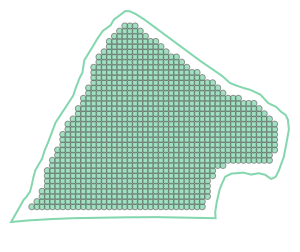

In [704]:
norm_pole.boundary.union(grid_xy)

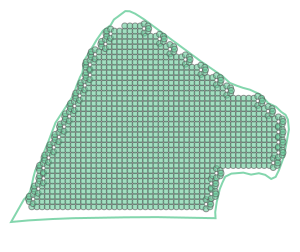

In [705]:
norm_pole.boundary.union(MultiPoint(path_line))

In [706]:
path_line[-1].coords[0]

(498386.7909846434, 5898508.931388164)

# Добавляем обход по периметру

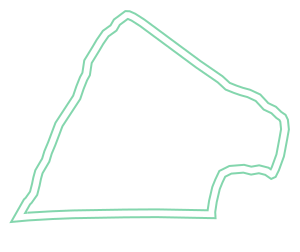

In [707]:
norm_pole.boundary.union(norm_pole.boundary.parallel_offset(param_step*1.5, 'right', join_style=2, mitre_limit=2))

In [708]:
bound_1 = norm_pole.boundary.parallel_offset(param_step*0.5, 'right', join_style=2, mitre_limit=2)

In [709]:
bound_2 = norm_pole.boundary.parallel_offset(param_step*1.5, 'right', join_style=2, mitre_limit=2)

In [710]:
len(bound_1.coords)

60

In [711]:
len(bound_2.coords)

58

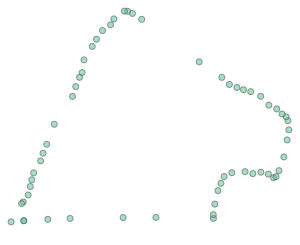

In [712]:
MultiPoint(bound_1.coords)

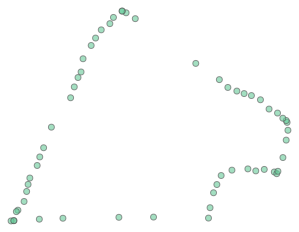

In [713]:
MultiPoint(bound_2.coords)

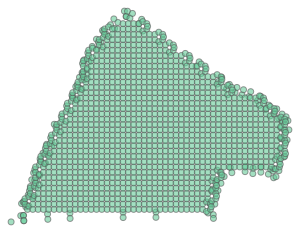

In [714]:
MultiPoint(bound_2.coords).union(MultiPoint(bound_1.coords)).union(MultiPoint(path_line))

In [715]:
start_point = Point(minx, miny)
point_1 = nearest_points(MultiPoint(bound_1.coords), start_point)[0]
ix_point_1 = list(bound_1.coords).index(point_1.coords[0])
ix_point_1, len(bound_1.coords)

(58, 60)

In [716]:
path_full = bound_1.coords[ix_point_1:]+bound_1.coords[:ix_point_1]
len(path_full)

60

In [717]:
point_2 = nearest_points(MultiPoint(bound_2.coords), Point(path_full[-1]))[0]
ix_point_2 = list(bound_2.coords).index(point_0.coords[0])
ix_point_2, len(bound_2.coords)

(55, 58)

In [718]:
path_full += bound_2.coords[ix_point_2:]+bound_2.coords[:ix_point_2]
len(path_full)

118

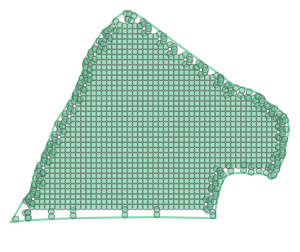

In [719]:
path_full += path_line

norm_pole.boundary.union(MultiPoint(path_full))

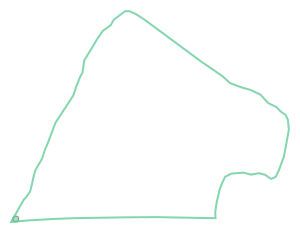

In [831]:
# смотрим на начальную и конечную точки маршрута
norm_pole.boundary.union(Point(path_full[0])).union(Point(path_full[-1]))

In [832]:
# Будем возвращаемся вдоль периметра по первому контуру
point_3 = nearest_points(MultiPoint(bound_1.coords), Point(path_line[-1]))[0]
ix_point_3 = list(bound_1.coords).index(point_3.coords[0])
ix_point_3, len(bound_1.coords)

(38, 60)

58 38


'Длина маршрута возврата в одну сторону 603.4346951654838'

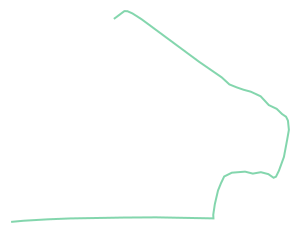

'Длина маршрута возврата в обратную сторону 243.76672459440204'

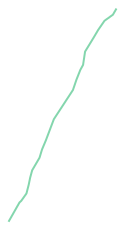

In [833]:
# Вычисляем длины маршрутов возврата в исходную точку по часовой и против часовой стрелки
if ix_point_1 == ix_point_3:
    pass
    # Ничего делать не надо, уже в начальной точке
else:
    print(ix_point_1, ix_point_3)
    if ix_point_1 > ix_point_3:
        path_anticlockwise = LineString(list(bound_1.coords)[ix_point_3:ix_point_1] + [point_1])
        path_clockwise = LineString(
            list(bound_1.coords)[ix_point_3::-1] + list(bound_1.coords)[:ix_point_1:-1] + [point_1])
    else: # ix_point_1 < ix_point_3
        path_anticlockwise = LineString(list(bound_1.coords)[ix_point_3:] + list(bound_1.coords)[:ix_point_1] + [point_1])
        path_clockwise = LineString(list(bound_1.coords)[ix_point_3:ix_point_1:-1] + [point_1])
    display(f"Длина маршрута возврата в одну сторону {path_clockwise.length}", path_clockwise)
    display(f"Длина маршрута возврата в обратную сторону {path_anticlockwise.length}", path_anticlockwise)
    
    # Сравниваем длины маршрутов по часовой и против часовой стрелки и присоедниняем минимальный маршрут к пути
    if path_clockwise.length < path_anticlockwise.length:
        path_full += path_clockwise.coords
    else:
        path_full += path_anticlockwise.coords

In [834]:
print(f"Длина маршрута: {LineString(path_full).length}")
print(f"Точек в маршруте: {len(path_full)}")

Длина маршрута: 9010.166876192621
Точек в маршруте: 1403


'Стартовые 300 точек пути'

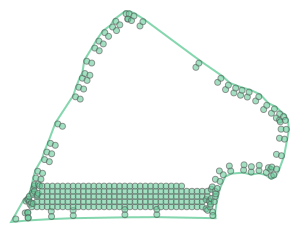

'Финальные 300 точек пути'

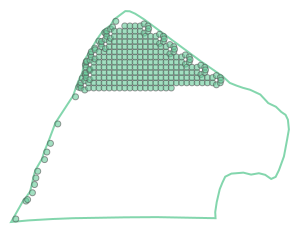

'Весь путь'

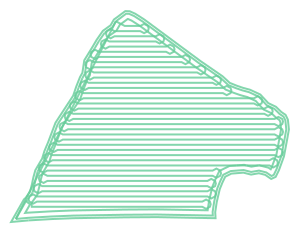

In [835]:
display('Стартовые 300 точек пути', norm_pole.boundary.union(MultiPoint(path_full[:300])))
display('Финальные 300 точек пути', norm_pole.boundary.union(MultiPoint(path_full[-300:])))
display('Весь путь', norm_pole.boundary.union(LineString(path_full)))

In [836]:
# Перед сглаживанием поворотов - делим длинные участки, объединить можно будет потом
point_prev = Point(path_full[0])
new_path_full = [point_prev.coords[0]]
for x in path_full[1:]:
    point_cur = Point(x)
    line = LineString([point_prev, point_cur])
    dist = line.length
    while dist>5:
        cp = line.interpolate(5)
        new_path_full += [cp.coords[0]]
#         print(cp, point_prev.distance(cp))
        point_prev = cp
        line = LineString([point_prev, point_cur])
        dist = line.length
    new_path_full += [point_cur.coords[0]]
    point_prev = point_cur

In [838]:
# # Прописываем повороты
# # a2+b2!<c2
# point_prev_1 = Point(new_path_full[0])
# point_prev_2 = point_prev_1
# dist_a = 100
# new_path_full2 = [point_prev_2.coords[0]]
# for i, x in enumerate(new_path_full[1:]):
#     print(i,len(new_path_full2), dist_a, dist_b, dist_c)
#     point_cur = Point(x)
#     dist_a = point_prev_1.distance(point_prev_2)
#     dist_b = point_prev_2.distance(point_cur)
#     dist_c = point_prev_1.distance(point_cur)
#     while (dist_a*dist_a+dist_b*dist_b)<(dist_c*dist_c-0.1):
# #         print(dist_a, dist_b, dist_c)
#         new_path_full2 = new_path_full2[:-1]
#         point_prev_2 = point_prev_1
#         point_prev_1 = Point(new_path_full2[-1])
#         dist_a = point_prev_1.distance(point_prev_2)
#         dist_b = point_prev_2.distance(point_cur)
#         dist_c = point_prev_1.distance(point_cur)
#     new_path_full2 += [point_cur.coords[0]]
#     point_prev_1 = point_prev_2
#     point_prev_2 = point_cur

# len(new_path_full2)

# display('Весь путь', norm_pole.boundary.union(LineString(new_path_full2)))

# Сгладить углы не успели, времени не хватило

# Вращаем обратно

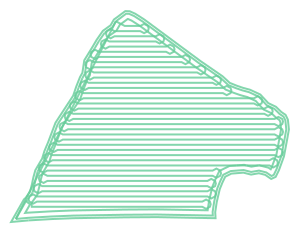

In [849]:
path_f = norm_pole.boundary.union(LineString(path_full))
path_f

'Поворачиваем на угол 0.74762 рад.'

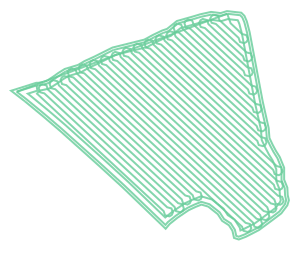

In [853]:
display(f"Поворачиваем на угол {-alpha:.5f} рад.")
path_result = affinity.rotate(path_f, alpha, use_radians = True, origin='centroid')
path_result

In [860]:
path_flat = mapping(path_result)['coordinates'][2:]

In [562]:
# Смотрим на пример

shp_track_example = gpd.read_file("Trimble/AgGPS/Data/Hackathon/Hackathon/3_2/LineFeature.shp")
shp_track_example.set_crs(epsg=4326, inplace=True)
list(shp_track_example.geometry[0].coords)

[(27.01890117981722, 53.323636127351705),
 (27.018302950803267, 53.3234231966127),
 (27.017628459281223, 53.32316471316772),
 (27.016928427013543, 53.32289107998428),
 (27.01657193576109, 53.32268577336939),
 (27.0164192308805, 53.322602189336386),
 (27.016508263761413, 53.322495721519985),
 (27.01667373901482, 53.3224121371147),
 (27.018913950190043, 53.32106638416487),
 (27.019015753443767, 53.3210359790694),
 (27.019155687951542, 53.32102083023284),
 (27.01925749120527, 53.321043607204935),
 (27.019270261578086, 53.32111204548662),
 (27.018875639071588, 53.323544917493194),
 (27.018722934190997, 53.323544917493194),
 (27.018659262191317, 53.32349925877466),
 (27.018672032564133, 53.323385165480886),
 (27.01910478632468, 53.32119563243844),
 (27.019053884697815, 53.32116522743507),
 (27.018977442325316, 53.32116522743507),
 (27.018926540698455, 53.32118811176824),
 (27.01846842605668, 53.323354762037575),
 (27.01836662280295, 53.32337764519657),
 (27.018264819549227, 53.3233319862990

<AxesSubplot:>

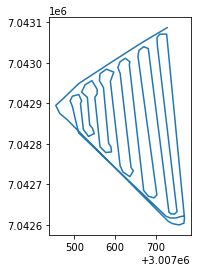

In [563]:
shp_track_example.to_crs(epsg=3857, inplace=True)
shp_track_example.plot()

In [564]:
import pandas as pd
from ipywidgets import HTML
from ipyleaflet import Map, Marker, Popup
from ipyleaflet import AntPath, WidgetControl
from ipywidgets import IntSlider, jslink

In [565]:
# WGS84
m = Map(center=(53.323,27.019), zoom=16)

In [566]:
m_path = AntPath(
    locations=list((y,x) for (x,y) in shp_track_example.to_crs(epsg=4326).geometry[0].coords),
    dash_array=[1, 10],
    delay=1000,
    color='#9500ff',
    pulse_color='#9500ff'
)

In [567]:
m.add_layer(m_path)


In [568]:
display(m)

Map(center=[53.323, 27.019], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [844]:
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import geopandas
import json

countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

shp_pole_example = gpd.read_file("Trimble/AgGPS/Data/Hackathon/Hackathon/3_2/Boundary.shp")
shp_pole_example.set_crs(epsg=4326, inplace=True)

m = Map(center=(53.322,27.019), zoom = 16, basemap=basemaps.OpenStreetMap.HOT)
m = Map(center=(53.322,27.019), zoom = 16, basemap=basemaps.Esri.WorldImagery)


geo_pole = GeoData(geo_dataframe = shp_pole_example.to_crs(epsg=4326),
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

geo_path = GeoData(geo_dataframe = shp_track_example.to_crs(epsg=4326),
                   style={'color': 'purple', 'opacity':3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Rivers')

m.add_layer(geo_pole)
m.add_layer(m_path)
m.add_control(LayersControl())

m

Map(center=[53.322, 27.019], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…